## Selection and plotting of KRAS Case study subset

This notebook is to evaluate the metrics (MSE, E-distance, and Augur) for separating KRAS targeting treatments against KRAS cell line context.

In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/home/ubuntu/frameshift-1/data"

In [2]:
edist = pd.read_csv(f"{data_dir}/Tahoe96M_edist_matrix_within_plate.tsv", index_col=0, sep='\t')
edist.head(2)

drug_meta = edist.columns.to_frame().rename(columns={0: "drug_longfmt"})
#replace propanediol, hydrate to remove the space
drug_meta['drug_longfmt'] = drug_meta['drug_longfmt'].str.replace("propanediol, hydrate", "propanediol,hydrate")

drug_meta = drug_meta['drug_longfmt'].str.replace("'", "").str.replace(", uM)]", "").str.replace('[(', '').str.split(", ", expand=True)
drug_meta.columns = ["drug", "dose"]

#define only top dose
drug_meta5 = drug_meta[(drug_meta['dose'] == "5.0")]

#get the dose of 5 only
edist5 = edist.loc[:, drug_meta5.index]
edist5.columns = drug_meta5['drug']
#drop cell lines that have NA
print(edist5.shape)
edist5 = edist5.dropna(axis=0)
print(edist5.shape)
edist5.head(3)


(50, 379)
(48, 379)


drug,(R)-Verapamil (hydrochloride),(S)-Crizotinib,18β-Glycyrrhetinic acid,4EGI-1,5-Azacytidine,5-Fluorouracil,8-Hydroxyquinoline,9-ING-41,APTO-253,AT7519,...,Vortioxetine,XRK3F2,Zileuton,c-Kit-IN-1,crizotinib,olaparib,palbociclib,venetoclax,vincristine,γ-Oryzanol
cell_line,,,,,,,,,,,,,,,,,,,,,
A549,0.414523,1.602780,0.822553,0.604181,0.215496,1.264086,0.254773,2.132352,0.226501,0.309678,...,1.021167,2.533169,0.159264,4.845418,1.714201,0.789772,1.886109,7.662991,2.494245,1.303884
COLO 205,0.357076,0.998614,0.697818,0.561836,0.517479,0.429730,0.302023,2.327751,0.292322,0.615865,...,0.565004,2.939890,0.131060,2.140641,1.977494,0.376860,0.783737,3.343617,3.152886,0.318881
HT-29,0.366198,1.423640,0.806040,1.063001,0.630798,0.666058,0.449617,2.477781,0.431455,0.662499,...,0.688498,3.724571,0.192667,5.069367,3.111637,0.477851,0.261656,2.368669,3.488894,0.361513


## Get drug MOA annot

In [3]:
path = "/home/ubuntu/frameshift-1/data/metadata/drug_metadata.parquet"
d_annot = pd.read_parquet(path, engine='pyarrow')
d_annot.head(2)

,drug,targets,moa-broad,moa-fine,human-approved,clinical-trials,gpt-notes-approval,canonical_smiles,pubchem_cid
0,Talc,None,unclear,unclear,yes,yes,Talc used in pharma and cosmetics; safety unde...,[OH-].[OH-].[O-][Si]12O[Si]3(O[Si](O1)(O[Si](O...,165411828.0
1,Bortezomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma and mantle cell ...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0


In [4]:
# prop_has_effect = (edist5 > 10).mean().sort_values().to_frame()
# prop_has_effect['moa-fine'] = d_annot.set_index('drug')['moa-fine']
# prop_has_effect

### Stratifying patients by KRAS mutation

In [5]:
## open parquet in python
path = f"{data_dir}/cell_line_metadata.parquet"
cl_meta = pd.read_parquet(path, engine='pyarrow')
cl_meta.head(2)

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor


In [6]:
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(edist5.index)]
kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")

g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'").query("Organ == 'Lung'")['cell_name']
not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'").query("Organ == 'Lung'")['cell_name']


not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")
#subset so that it exists in the e-distance
not_kras_driven = not_kras_driven[not_kras_driven['cell_name'].isin(edist5.index)]
#drop any cell lines that have BRAF
braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated").query("Organ == 'Lung'")['cell_name'].unique()

print(len(krasNo_brafNo), len(g12c), len(not_g12c))

nominated = list(krasNo_brafNo[0:2]) + list(g12c[0:2]) + list(not_g12c[0:2])
# nominated = list(krasNo_brafNo) + list(g12c) + list(not_g12c)
nominated

2 4 7


['NCI-H661', 'SW 1271', 'HOP62', 'NCI-H23', 'A549', 'SHP-77']

In [8]:
##Nominated drugs
drugs = ['RMC-6236','Adagrasib','Celecoxib', 'Homoharringtonine', 'Dinaciclib', 'DMSO_TF']
drug_longfmt = drug_meta5.query("drug in @drugs").index.tolist() + drug_meta.query("drug == 'DMSO_TF'").index.tolist()
drugs

['RMC-6236',
 'Adagrasib',
 'Celecoxib',
 'Homoharringtonine',
 'Dinaciclib',
 'DMSO_TF']

## Plotting metrics against KRAS status

In [ ]:
picked_drugs = ["[('Adagrasib', 5.0, 'uM')]",
 "[('Celecoxib', 5.0, 'uM')]",
 "[('Dinaciclib', 5.0, 'uM')]",
 "[('Homoharringtonine', 5.0, 'uM')]",
 "[('RMC-6236', 5.0, 'uM')]",]
# cell_lines = ['HOP-92',
#  'NCI-H1299',
#  'NCI-H661',
#  'NCI-H596',
#  'SW 1271',
#  'EKVX',
#  'HOP62',
#  'NCI-H23',
#  'NCI-H1792',
#  'NCI-H2030',
#  'A549',
#  'SHP-77',
#  'SW 900',
#  'NCI-H1573',
#  'NCI-H460',
#  'A-427',
#  'NCI-H2347']
print(len(cell_lines))
cell_lines = pd.Series(cell_lines)
cell_lines = cell_lines[cell_lines.isin(msedf.index)]
print(len(cell_lines))
msedf.loc[cell_lines, picked_drugs]

In [51]:
metrics = {
	'MSE\n(scaled to cell line max)': pd.read_csv("/home/ubuntu/frameshift-1/data/MSE.tsv", sep="\t", header=0, index_col=0),
	'E-distance (log10 + 1)': np.log10(edist + 1),
	'Augur': pd.read_csv("/home/ubuntu/frameshift-1/carlota/augur_allcellines/augur_combined_summary_matrix.csv").drop(columns='Plate').groupby('Treatment').mean().T
}

mse_key = 'MSE\n(scaled to cell line max)'
metrics[mse_key] = metrics[mse_key].loc[:, drug_meta5.index].copy()
metrics[mse_key] = metrics[mse_key].div(metrics[mse_key].max(axis=1), axis=0) #scale so that each row max is 1



metrics['Augur'].columns = drug_meta5.reset_index().set_index('drug')['index'].loc[metrics['Augur'].columns] #set columns to the 'drugname_drugconc' annot

/home/ubuntu/miniforge3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


label
No KRAS       26
KRAS Other    18
KRAS G12C      6
Name: count, dtype: int64


/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_tick

label
No KRAS       26
KRAS Other    18
KRAS G12C      6
Name: count, dtype: int64


/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


label
No KRAS       26
KRAS Other    18
KRAS G12C      6
Name: count, dtype: int64


/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_228859/291270965.py:50: UserWarning: set_tick

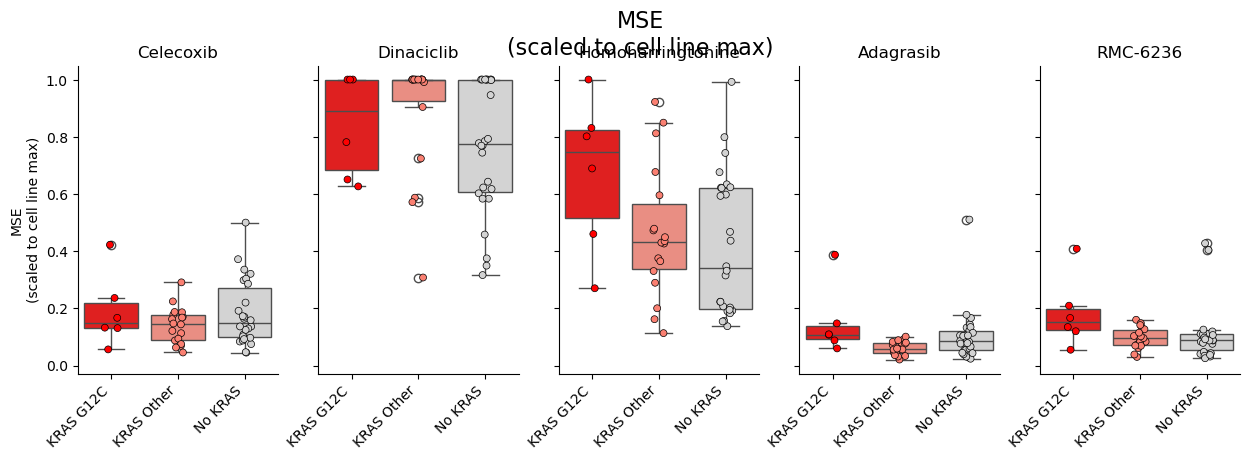

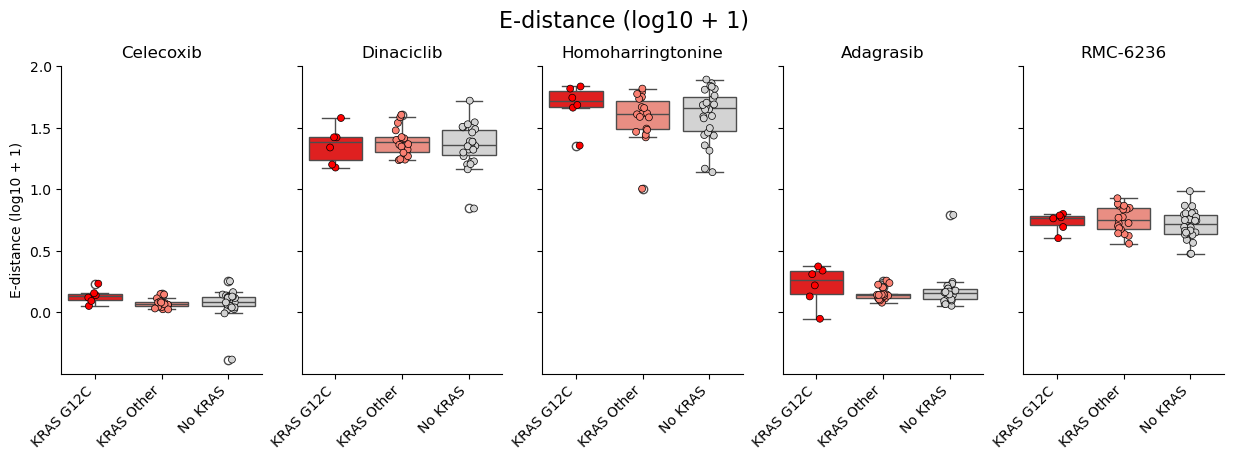

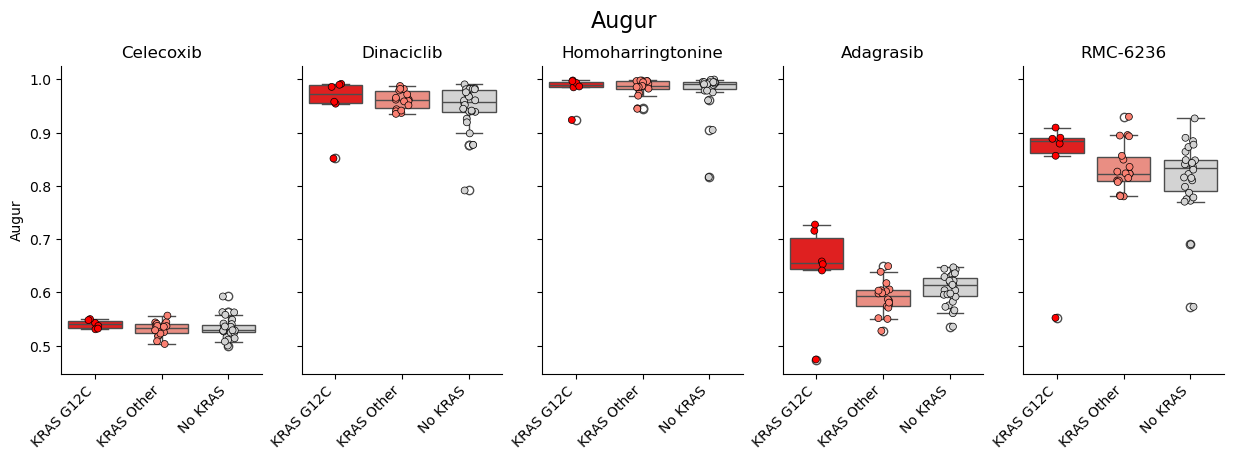

In [52]:
picked_drugs = [
	"[('Celecoxib', 5.0, 'uM')]",
	 "[('Dinaciclib', 5.0, 'uM')]",
 	"[('Homoharringtonine', 5.0, 'uM')]",
	"[('Adagrasib', 5.0, 'uM')]",
 	"[('RMC-6236', 5.0, 'uM')]",
	]

for m, df in metrics.items():
	m_meta = pd.DataFrame(columns=['label'], index=df.index)
	# mse_meta
	#label if kras, krasg12c, or not
	kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
	kras_driven_cell_lines = kras_driven['cell_name'].unique()
	kras_driven = kras_driven[kras_driven['cell_name'].isin(df.index)]
	# kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")

	# kras_driven
	g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")['cell_name']
	m_meta.loc[g12c, 'label'] = 'KRAS G12C'

	not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'")['cell_name']
	m_meta.loc[not_g12c, 'label'] = 'KRAS Other'

	# len(g12c), len(not_g12c), not kras
	not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")['cell_name'].unique()
	# # #drop any cell lines that have BRAF
	# braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
	# krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated")['cell_name'].unique()
	# krasNo_brafYes = not_kras_driven.query("cell_name in @braf_mutated")['cell_name'].unique()
	# # krasNo_brafNo
	# m_meta.loc[m_meta.index.isin(krasNo_brafNo), 'label'] = 'not_kras_not_braf'
	# m_meta.loc[m_meta.index.isin(krasNo_brafYes), 'label'] = 'not_kras_braf'

	m_meta.loc[m_meta.index.isin(not_kras_driven), 'label'] = 'No KRAS'

	print(m_meta['label'].value_counts(dropna=False))

	# order = ['kras_g12c', 'kras_not_g12c', 'not_kras_not_braf', 'not_kras_braf']
	order = ['KRAS G12C', 'KRAS Other', 'No KRAS']
	hues = ['red', 'salmon', 'lightgrey']
	palette = dict(zip(order, hues))

	nplot = len(picked_drugs)
	fig, axs = plt.subplots(1, nplot, figsize=(nplot*3, 4), sharey=True)
	sns.despine()
	for drug, ax in zip(picked_drugs, axs.flatten()):
		sns.boxplot(x=m_meta['label'], y=df[drug], ax=ax, order=order, hue=m_meta['label'], palette = palette, legend=False)
		sns.stripplot(x=m_meta['label'], y=df[drug], ax=ax, order=order, hue=m_meta['label'], palette = palette, legend=False, edgecolor='black', linewidth=0.5)
		ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
		# ax.set_title(drug)
		drug_name = drug_meta5.loc[drug, 'drug']
		ax.set_title(drug_name)
		ax.set_xlabel('')
		ax.set_ylabel(m)
	fig.suptitle(f"{m}", fontsize=16, y=1.02)